In [1]:
import numpy as np
import pandas as pd
from scipy.stats import mstats
import matplotlib.pyplot as plt
import seaborn as sns
import pystan
%matplotlib inline
plt.style.use("ggplot")

In [2]:
data = pd.read_csv('./input/data-conc-2.txt')
data.head()

,PersonID,Time1,Time2,Time4,Time8,Time12,Time24
0,1,2.4,5.0,7.5,11.9,12.5,12.7
1,2,1.4,3.9,4.4,7.7,6.4,8.3
2,3,5.2,9.4,19.4,20.2,22.7,24.9
3,4,6.7,12.6,19.1,23.4,25.8,26.1
4,5,0.3,4.7,7.0,10.2,12.9,14.8


In [3]:
data_melt = data.melt(id_vars=['PersonID'])
data_melt['variable'] = data_melt['variable'].replace({'Time1':1, 'Time2':2, 'Time4':4, 'Time8':8, 'Time12':12, 'Time24':24})

In [4]:
stan_model = """

data {
  int N;
  int T;
  real Time[T];
  real Y[N, T];
  int T_new;
  real Time_new[T_new];
}


parameters {
  real a0;
  real b0;
  real log_a[N];
  real log_b[N];
  real<lower=0> s_a;
  real<lower=0> s_b;
  real<lower=0> s_Y;
}

transformed parameters {
  real<lower=0, upper=100> a[N];
  real<lower=0, upper=5> b[N];
  for (n in 1:N){
    a[n] = exp(log_a[n]);
    b[n] = exp(log_b[n]);
  }
}

model {
  for (n in 1:N){
    log_a[n] ~ normal(a0, s_a);
    log_b[n] ~ normal(a0, s_b);    
  }
  
  for (n in 1:N){
    for (t in 1:T){
      Y[n, t] ~ normal(a[n] * (1 - exp(-b[n] * Time[t])), s_Y);
    }
  }
}

generated quantities {
  real y_new[N, T_new];
  real y_pred[N, T];  
  
  for (n in 1:N){
    for (t in 1:T_new){
      y_new[n, t] = normal_rng(a[n] * (1 - exp(-b[n] * Time_new[t])), s_Y);
    }
  }
  
  for (n in 1:N){
    for (t in 1:T){
      y_pred[n, t] = normal_rng(a[n] * (1 - exp(-b[n] * Time[t])), s_Y);
    }
  }  
  
}
"""

In [5]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_9dca5688e1e3987875f221f7a66afb1d NOW.


In [6]:
stan_data = {}
stan_data['N'] = data.shape[0]
stan_data['Time'] = np.sort(data_melt['variable'].unique())
stan_data['T'] = len(stan_data['Time'])
stan_data['Y'] = data.drop(['PersonID'], axis=1)
stan_data['Time_new'] = [60]
stan_data['T_new'] = len(stan_data['Time_new'])

In [7]:
fit = sm.sampling(stan_data)

In [8]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_9dca5688e1e3987875f221f7a66afb1d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                mean se_mean     sd    2.5%     25%     50%     75%  97.5%  n_eff   Rhat
a0              -1.1  1.8e-3   0.11   -1.32   -1.17    -1.1   -1.02  -0.88   4214    1.0
b0           -1.0e13  7.4e12 2.1e13 -8.5e13 -5.5e12 -2.0e12 -2.0e11 1.7e12      8   1.38
log_a[1]        2.53  1.5e-3    0.1    2.33    2.47    2.53    2.59   2.71   4195    1.0
log_a[2]        1.99  2.1e-3   0.15    1.69     1.9    2.01    2.09   2.26   4976    1.0
log_a[3]        3.17  7.4e-4   0.05    3.07    3.14    3.17    3.21   3.28   5066    1.0
log_a[4]        3.25  6.4e-4   0.05    3.17    3.22    3.26    3.29   3.35   5011    1.0
log_a[5]         2.6  1.8e-3   0.11    2.38    2.53     2.6    2.67   2.82   3782    1.0
log_a[6]        2.72  1.7e-3    0.1    2.53    2.66    2.72

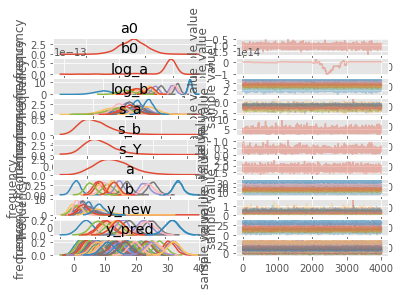

In [9]:
fig = fit.plot()

In [10]:
stan_model_b = """

data {
  int N;
  int T;
  vector[T] Time;
  matrix[N, T] Y;
  int T_new;
  real Time_new[T_new];
}


parameters {
  real a0;
  real b0;
  vector[N] log_a;
  vector[N] log_b;
  real<lower=0> s_a;
  real<lower=0> s_b;
  real<lower=0> s_Y;
}

transformed parameters {
  vector[N] a;
  vector[N] b;
  matrix[N, T] mu;
  
  a = exp(log_a);
  b = exp(log_b);
  
  for (t in 1:T){
    for (n in 1:N){
      mu[n, t] = a[n] * (1 - exp(-b[n] * Time[t]));
    }
  }
}

model {
  log_a ~ normal(a0, s_a);
  log_b ~ normal(b0, s_b);
  to_vector(Y) ~ normal(to_vector(mu), s_Y);
}

generated quantities {
  real y_new[N, T_new];
  real y_pred[N, T];  
  
  for (n in 1:N){
    for (t in 1:T_new){
      y_new[n, t] = normal_rng(a[n] * (1 - exp(-b[n] * Time_new[t])), s_Y);
    }
  }
  
  for (n in 1:N){
    for (t in 1:T){
      y_pred[n, t] = normal_rng(a[n] * (1 - exp(-b[n] * Time[t])), s_Y);
    }
  }  
  
}
"""

In [11]:
sm_b = pystan.StanModel(model_code=stan_model_b)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b80d3f8d33390a7e8e8c20cebaeba46f NOW.


In [12]:
fit_b = sm_b.sampling(stan_data)

In [13]:
fit_b


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_b80d3f8d33390a7e8e8c20cebaeba46f.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0          2.86  1.4e-3   0.11   2.65   2.79   2.86   2.93   3.08   5724    1.0
b0         -1.18  2.0e-3   0.12  -1.43  -1.25  -1.17   -1.1  -0.95   3713    1.0
log_a[1]    2.56  1.4e-3    0.1   2.37   2.49   2.56   2.62   2.74   4464    1.0
log_a[2]    2.11  2.3e-3   0.15   1.83   2.02   2.11   2.21    2.4   4064    1.0
log_a[3]    3.17  7.2e-4   0.05   3.07   3.14   3.17    3.2   3.27   4895    1.0
log_a[4]    3.26  6.4e-4   0.05   3.16   3.22   3.26   3.29   3.35   5176    1.0
log_a[5]    2.64  1.9e-3   0.11   2.42   2.56   2.63   2.71   2.87   3595    1.0
log_a[6]    2.75  1.5e-3    0.1   2.56   2.68   2.74   2.81   2.94   3960    1.0
log_a[7]    2.69  1.2e-3   0.09   2.52   2

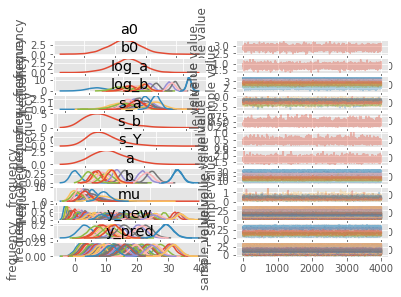

In [14]:
fig = fit_b.plot()